<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\somic\AppData\Local\Temp\ipykernel_10260\3918690883.py:15: SyntaxWarning: invalid escape sequence '\m'
  model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)



0: 224x224 Hydrant 0.95, Chimney 0.05, Crosswalk 0.00, Car 0.00, Bicycle 0.00, 33.9ms
Speed: 0.0ms preprocess, 33.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)
probs here ultralytics.engine.results.Probs object with attributes:

data: tensor([1.3917e-05, 4.2607e-07, 2.4558e-07, 2.8092e-05, 4.8638e-02, 1.2873e-04, 9.5118e-01, 4.0666e-08, 3.6651e-15, 1.9598e-06, 2.9536e-06, 1.7551e-06, 3.4682e-09])
orig_shape: None
shape: torch.Size([13])
top1: 6
top1conf: tensor(0.9512)
top5: [6, 4, 5, 3, 0]
top5conf: tensor([9.5118e-01, 4.8638e-02, 1.2873e-04, 2.8092e-05, 1.3917e-05])
[6, 4, 5, 3, 0]
confidence score here tensor(0.0486) this is the confidence score
Enters here
Step 0, Loss: -0.0486379973590374, Target Class Detected: True

0: 224x224 Hydrant 0.95, Chimney 0.05, Crosswalk 0.00, Car 0.00, Bicycle 0.00, 28.7ms
Speed: 0.0ms preprocess, 28.7ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)
probs here ultralytics.engine.results.Probs object with attr

C:\Users\somic\AppData\Local\Temp\ipykernel_10260\3918690883.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss =  torch.tensor(-confidence_score.data, requires_grad=True, device=device)  # Negative to maximize the confidence score


0: 224x224 Hydrant 0.95, Chimney 0.05, Crosswalk 0.00, Car 0.00, Bicycle 0.00, 57.0ms
Speed: 0.0ms preprocess, 57.0ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)
probs here ultralytics.engine.results.Probs object with attributes:

data: tensor([1.3917e-05, 4.2607e-07, 2.4558e-07, 2.8092e-05, 4.8638e-02, 1.2873e-04, 9.5118e-01, 4.0666e-08, 3.6651e-15, 1.9598e-06, 2.9536e-06, 1.7551e-06, 3.4682e-09])
orig_shape: None
shape: torch.Size([13])
top1: 6
top1conf: tensor(0.9512)
top5: [6, 4, 5, 3, 0]
top5conf: tensor([9.5118e-01, 4.8638e-02, 1.2873e-04, 2.8092e-05, 1.3917e-05])
[6, 4, 5, 3, 0]
confidence score here tensor(0.0486) this is the confidence score
Enters here

0: 224x224 Hydrant 0.95, Chimney 0.05, Crosswalk 0.00, Car 0.00, Bicycle 0.00, 114.4ms
Speed: 0.0ms preprocess, 114.4ms inference, 4.3ms postprocess per image at shape (1, 3, 224, 224)
probs here ultralytics.engine.results.Probs object with attributes:

data: tensor([1.3917e-05, 4.2607e-07, 2.4558e-07, 2.8

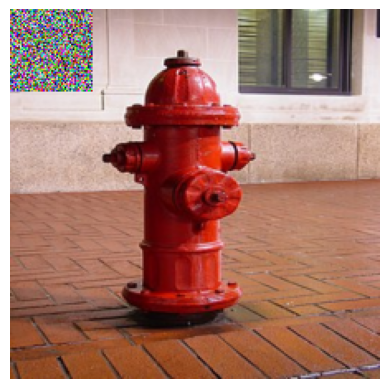


0: 224x224 Hydrant 0.95, Chimney 0.05, Crosswalk 0.00, Car 0.00, Bicycle 0.00, 36.9ms
Speed: 0.0ms preprocess, 36.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)



: 

In [ ]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO


# Load the pre-trained ResNet-50 model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)


# Download ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with urllib.request.urlopen(url) as response:
    labels = json.loads(response.read().decode())

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Overlay patch onto image without modifying the original image
def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

# Visualize the patched image
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()


def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    # Load the base image
    image = load_image(image_path).to(device)
    
    # Initialize random patch with the required size and set requires_grad=True to enable optimization
    patch = torch.rand((3, *patch_size), requires_grad=True, device=device)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch to the image at a specified location (top-left corner here)
        patched_image = apply_patch_direct(image, patch, (0, 0))
        
        # Forward pass through the YOLO model
        results = model.predict(patched_image)  # `results` is a Results object

        

        # Extract detection results for the target class
        loss = torch.tensor(0.0, requires_grad=True, device=device)
        
        # Iterate through detections in the Results object
        for r in results:
            # Assuming r.probs is a list or tensor of class probabilities for this detection
            probs = r.probs  # Probabilities for each class
            print("probs here", probs)
            print(r.probs.top5)
            
            # Get the confidence score for the target class
            confidence_score = probs[target_class] 
            print("confidence score here", confidence_score.data, "this is the confidence score")
            # print("confidence score", [x for x in confidence_score.data])

        # If there are no detections for the target class, set loss to zero

        loss = criterion(result, label)


            # if confidence_score.data > 0:
            #     # Calculate loss to maximize the confidence of the target class
            #     # loss = torch.tensor(-torch.stack(target_confidences).mean(), requires_grad=True)  # Negative to maximize the confidence score
            #     loss =  torch.tensor(-confidence_score.data, requires_grad=True, device=device)  # Negative to maximize the confidence score
            #     print("Enters here")
            # else:
            #     loss = torch.tensor(0.0, requires_grad=True, device=device)  # No detections, no loss contribution

            # Backward pass to update the patch
            loss.to(device)
            loss.backward()
            optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            print(f"Step {step}, Loss: {loss.item()}, Target Class Detected: {confidence_score.data > 0}")

    return patch



# Example usage: Define the target class and train the patch on an example image
target_class = 4  # Replace with your desired target class index
image_path = "../assets/hydrant_hd.jpg"  # Replace with the path to your image
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)


# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)

patched_image = apply_patch_direct(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image
output = model(patched_image)

results = model.predict(patched_image, device=0, save=True, save_txt=True, save_conf=True, show_boxes=True, save_crop=True)
print(results)
# _, predicted_idx = torch.max(output, 1)
# predicted_label = labels[predicted_idx.item()]


In [2]:
# Load the pre-trained ResNet-50 model
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)

model.clases

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\somic\AppData\Local\Temp\ipykernel_28008\3265192497.py:14: SyntaxWarning: invalid escape sequence '\m'
  model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)
C:\Users\somic\AppData\Local\Temp\ipykernel_28008\3265192497.py:14: SyntaxWarning: invalid escape sequence '\m'
  model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)


AttributeError: 'YOLO' object has no attribute 'clases'

In [8]:
#!pip install -U ultralytics

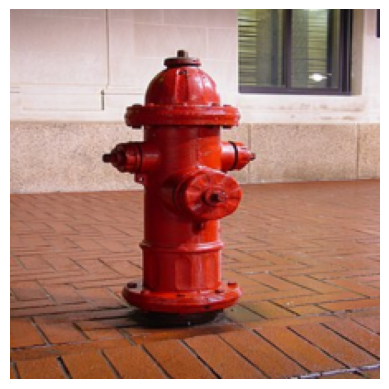

In [6]:
visualize_image(image)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = YOLO("..\models\YOLO_v11\yolo11n-cls.pt").to(device)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\somic\AppData\Local\Temp\ipykernel_34784\1148212666.py:2: SyntaxWarning: invalid escape sequence '\m'
  model = YOLO("..\models\YOLO_v11\yolo11n-cls.pt").to(device)


In [3]:
model.names

{0: 'Bicycle',
 1: 'Bridge',
 2: 'Bus',
 3: 'Car',
 4: 'Chimney',
 5: 'Crosswalk',
 6: 'Hydrant',
 7: 'Motorcycle',
 8: 'Mountain',
 9: 'Other',
 10: 'Palm',
 11: 'Stairs',
 12: 'Traffic Light'}

In [2]:
model_resnet = models.resnet50(pretrained=True)
model_resnet.eval()

NameError: name 'models' is not defined

Detected objects:
Class ID: 10
Class ID: 27
